 # Flu forecasting en France 

Dans le cadre d’un projet de machine learning avec objectif de prévision, nous avons travaillé sur la prévision des épidémies de grippe en France.

Nous avons utilisés différentes base de données: (population, données métrologiques, Liste des stations Météo, les requêtes de recherche sur Google, ainsi une base de données d'entraînement et de test contenant les régions et le Taux de Grippe).

Nous commençons par l'importation des données, le traitement, et enfin la modélisation.
Le but de ce projet, est de trouver l'algorithme, qui nous permettra d'avoir de bons prédictions. L'évaluation est basée sur le critère RMSE.


In [1]:
import pandas as pd # data processing
import numpy as np # algebra
from IPython.display import display
import os 
import matplotlib.pyplot as plt# visualization
import seaborn as sns
plt.style.use('ggplot')
import math
from math import sqrt
import glob
import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# Model
from scipy import stats
from sklearn import linear_model
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

#### Importer la base Train and Test data 

In [2]:
# Set working directory
os.chdir('C:/Users/abdel/Documents/Projects/Kaggle Flu_prediction/Flu')

# Read train and test data set
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
display(train.shape)
display(test.shape)

(11484, 5)

(3234, 4)

In [3]:
train.head()

,Id,week,region_code,region_name,TauxGrippe
0,3235,201352,42,ALSACE,7
1,3236,201352,72,AQUITAINE,0
2,3237,201352,83,AUVERGNE,88
3,3238,201352,25,BASSE-NORMANDIE,15
4,3239,201352,26,BOURGOGNE,0


In [4]:
test.head()

,Id,week,region_code,region_name
0,1,201642,42,ALSACE
1,2,201642,72,AQUITAINE
2,3,201642,83,AUVERGNE
3,4,201642,25,BASSE-NORMANDIE
4,5,201642,26,BOURGOGNE


In [5]:
# Add TauxGrippe = 0 in th test set
test['TauxGrippe'] = -1

# Combine train & test
data = pd.concat([train, test], 
                axis = 0
                )

# Dim of the new data
display(data.shape)

(14718, 5)

Notre base de données d'apprentissage contient 5 variables, et 4 variables dans la base Test. Nous combinons les deux datasets, et on ajoute une nouvelle variable (TauxGrippe) dans la base Test, en lui affectant la veleur -1, ça nous permettra de séparer les deux bases après un traitement globale.

#### convertir la date au YYYY-MM-DD format, et supprimer la colonne week

In [6]:
data.rename(columns={'region_name':'Region', 'week' :'date'}, inplace=True)
data['TauxGrippe'] = data.TauxGrippe.convert_objects(convert_numeric=True)

On nomme ces deux colonnes, pour pouvoir combiner cette dataset avec d'autres 

#### Importer List des Stations Meteo

In [7]:
# get ListedesStationsMeteo data
Station = pd.read_csv('ListedesStationsMeteo.csv',index_col='ID',sep=',', encoding = "ISO-8859-1")

In [8]:
Station.head()

,Nom,Latitude,Longitude,Altitude,Region
ID,,,,,
7005,ABBEVILLE,50.136000,1.834000,69,HAUTS-DE-FRANCE
7015,LILLE-LESQUIN,50.570000,3.097500,47,HAUTS-DE-FRANCE
7020,PTE DE LA HAGUE,49.725167,-1.939833,6,NORMANDIE
7027,CAEN-CARPIQUET,49.180000,-0.456167,67,NORMANDIE
7037,ROUEN-BOOS,49.383000,1.181667,151,NORMANDIE


On a créée la variable Region, en utilisant les coordonnées Latitude et Longitude, afin de trouver la région de chaque station mentionnée dans la colonne Nom.

#### Importer Metrologic Data

In [9]:
# get DonneesMeteorologiques data
path =r'C:/Users/abdel/Documents/Projects/Kaggle Flu_prediction/Flu/DonneesMeteorologiques/DonneesMeteorologiques'

all_files = glob.glob(path + "/*.csv")

Meteorologique_data = []

for filename in all_files:
    df = pd.read_csv(filename, header=0,sep=';',index_col='numer_sta')
    Meteorologique_data.append(df)
Meteo_data = pd.concat(Meteorologique_data)

In [10]:
Meteo_data.index.names = ['ID']

In [12]:
Meteo_data.head()

,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
ID,,,,,,,,,,,,,,,,,,,,,
7005,20040101000000,102160,-350,8,170,5.100000,273.250000,272.250000,93,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7015,20040101000000,102190,-290,8,160,3.100000,272.950000,271.950000,92,2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7020,20040101000000,101760,-380,6,180,13.900000,279.950000,275.450000,73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7027,20040101000000,102080,-370,6,170,5.100000,273.750000,272.850000,94,6000,...,7,0,7500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7037,20040101000000,102240,-310,6,180,4.100000,272.750000,271.650000,91,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Replace mq by NaN
Meteo_data.replace('mq', np.nan,inplace = True)

Les valeurs "mq" dans les différentes colonnes montrent qu'ils sagissent des valeurs nulls, on les remplace par NaN, pour facilier l'imputation des données

#### Merge MeteoData and StationData

In [14]:
Meteo_Station = pd.merge(Meteo_data, Station, on='ID')

In [15]:
Meteo_Station['date']=[str(i) for i in list(Meteo_Station.date)]
Meteo_Station['date'] = Meteo_Station['date'].apply(lambda x: x[0:8])
Meteo_Station['date'] = pd.to_datetime(Meteo_Station['date']).dt.strftime('%Y%U').astype(str).astype(int)

Pour la colonne date, on garde que l'année et le mois.

In [89]:
Meteo_Station.head(n=5)

,date,pmer,tend,cod_tend,dd,ff,t,td,u,pres,rafper,per,rr1,rr3,Latitude,Longitude,Altitude,Region
ID,,,,,,,,,,,,,,,,,,
7005,200400,102160.0,-350.0,8,170.0,5.1,273.25,272.25,93.0,101180.0,7.2,-10.0,NaN,0.0,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101760.0,-390.0,8,170.0,7.2,273.85,272.25,89.0,100790.0,8.7,-10.0,NaN,0.0,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101370.0,-390.0,6,190.0,4.1,273.45,272.45,93.0,100400.0,8.2,-10.0,NaN,0.0,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101040.0,-320.0,8,160.0,6.2,273.25,272.65,96.0,100080.0,9.8,-10.0,NaN,1.0,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,100690.0,-350.0,8,160.0,5.1,273.55,272.95,96.0,99730.0,8.2,-10.0,NaN,3.0,50.136,1.834,69,HAUTS-DE-FRANCE


#### Calculer les valeurs nulls

In [17]:
total = Meteo_Station.isnull().sum().sort_values(ascending = False)
percent = (Meteo_Station.isnull().sum()/Meteo_Station.isnull().count()*100).sort_values(ascending = False)
df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [18]:
df[df["Percent"]>=45]

,Total,Percent
tw,2163605,100.000000
sw,2163605,100.000000
Unnamed: 59,2163605,100.000000
nnuage4,2159022,99.788178
hnuage4,2159022,99.788178
ctype4,2155455,99.623314
phenspe4,2144457,99.114996
tx24,2128177,98.362548
tn24,2123582,98.150171
niv_bar,2115810,97.790955


Nous supprimons les valeurs qui ont 45% de valeurs manquantes.

In [19]:
high_Na = ['tw','sw','Unnamed: 59','nnuage4','hnuage4','ctype4','phenspe4','tx24','tn24','niv_bar',
           'geop','ctype3','hnuage3','raf10','etat_sol','tminsol','ht_neige','tend24','ctype2','tn12',
           'tx12','rr24','perssfrai','hnuage2','nnuage2','ssfrai','phenspe3','rr12', 'rr6','ctype1',
           'hnuage1','ch','nnuage1','cm','cl','w2','w1','nbas']

In [20]:
Meteo_Station = Meteo_Station.drop(high_Na, axis=1)

In [21]:
Meteo_Station.head()

,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,rr1,rr3,phenspe1,phenspe2,nnuage3,Nom,Latitude,Longitude,Altitude,Region
ID,,,,,,,,,,,,,,,,,,,,,
7005,200400,102160,-350,8,170,5.100000,273.250000,272.250000,93,NaN,...,NaN,0.000000,710.000000,1107.000000,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101760,-390,8,170,7.200000,273.850000,272.250000,89,NaN,...,NaN,0.000000,710.000000,1109.000000,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101370,-390,6,190,4.100000,273.450000,272.450000,93,6000,...,NaN,0.000000,710.000000,1108.000000,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101040,-320,8,160,6.200000,273.250000,272.650000,96,1000,...,NaN,1.000000,710.000000,1110.000000,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,100690,-350,8,160,5.100000,273.550000,272.950000,96,2500,...,NaN,3.000000,710.000000,1108.000000,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE


In [22]:
Meteo_Station.dtypes

date           int32
pmer          object
tend          object
cod_tend      object
dd            object
ff            object
t             object
td            object
u             object
vv            object
ww            object
n             object
hbas          object
pres          object
rafper        object
per           object
rr1           object
rr3           object
phenspe1      object
phenspe2      object
nnuage3       object
Nom           object
Latitude     float64
Longitude    float64
Altitude       int64
Region        object
dtype: object

In [23]:
# numeric columns
num_columns=['pmer', 'tend', 'dd', 'ff', 't', 'td', 'u','vv', 'ww', 'n', 'hbas',''
             'pres', 'rafper', 'per','rr1', 'rr3', 'phenspe1', 'phenspe2','nnuage3','Latitude','Longitude','Altitude']
for c in num_columns:
    Meteo_Station[c] = pd.to_numeric(Meteo_Station[c])

In [24]:
# category columns
cat_columns = ['Region','cod_tend']
Meteo_Station[cat_columns] = Meteo_Station[cat_columns].astype('category')

In [25]:
Meteo_Station.head()

,date,pmer,tend,cod_tend,dd,ff,t,td,u,vv,...,rr1,rr3,phenspe1,phenspe2,nnuage3,Nom,Latitude,Longitude,Altitude,Region
ID,,,,,,,,,,,,,,,,,,,,,
7005,200400,102160.0,-350.0,8,170.0,5.1,273.25,272.25,93.0,NaN,...,NaN,0.0,710.0,1107.0,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101760.0,-390.0,8,170.0,7.2,273.85,272.25,89.0,NaN,...,NaN,0.0,710.0,1109.0,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101370.0,-390.0,6,190.0,4.1,273.45,272.45,93.0,6000.0,...,NaN,0.0,710.0,1108.0,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,101040.0,-320.0,8,160.0,6.2,273.25,272.65,96.0,1000.0,...,NaN,1.0,710.0,1110.0,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE
7005,200400,100690.0,-350.0,8,160.0,5.1,273.55,272.95,96.0,2500.0,...,NaN,3.0,710.0,1108.0,NaN,ABBEVILLE,50.136,1.834,69,HAUTS-DE-FRANCE


In [28]:
Meteo_Station_1 = Meteo_Station.groupby(['Region','date'], as_index=False).mean()

On regroupe et on calcule la moyenne par région et date

In [29]:
Meteo_Station_1.head()

,Region,date,pmer,tend,dd,ff,t,td,u,vv,...,rafper,per,rr1,rr3,phenspe1,phenspe2,nnuage3,Latitude,Longitude,Altitude
0,AUVERGNE-RHONE-ALPES,200400,101510.985915,-9.263158,184.631579,3.905263,273.645789,271.255263,83.789474,8931.428571,...,8.186275,-16.470588,NaN,0.172727,1017.068966,1107.340426,7.142857,45.299735,4.175231,371.105263
1,AUVERGNE-RHONE-ALPES,200401,102026.964286,4.419643,149.107143,2.707143,274.974107,272.126786,81.513393,15388.554217,...,6.997080,-16.496350,NaN,0.167925,775.357664,1105.959677,6.083333,45.292250,4.181041,368.000000
2,AUVERGNE-RHONE-ALPES,200402,101143.592814,-35.675676,197.623318,4.661883,280.996637,277.063901,77.143498,20361.111111,...,12.243902,-13.252033,NaN,0.313990,790.788618,1044.793103,6.560000,45.295439,4.178566,369.322870
3,AUVERGNE-RHONE-ALPES,200403,101712.606061,30.226244,170.814480,3.710860,276.971267,274.374887,83.773756,12675.949367,...,8.525547,-16.861314,NaN,0.222000,846.737589,1101.230159,6.250000,45.286082,4.177594,369.371041
4,AUVERGNE-RHONE-ALPES,200404,101271.566265,8.063063,190.945946,4.413063,275.208559,270.899099,73.981982,21030.674847,...,10.597638,-14.251969,NaN,0.136318,896.701493,1076.537190,6.421053,45.288338,4.172962,369.198198


#### Faire un Merge Meteo_station avec la base qu'on a créée au début ( la combinaison de train et test) 

In [30]:
Data_2 = pd.merge(data, Meteo_Station_1,  how='left', left_on=['Region','date'], right_on = ['Region','date'])

In [31]:
Data_2.head()

,Id,date,region_code,Region,TauxGrippe,pmer,tend,dd,ff,t,...,rafper,per,rr1,rr3,phenspe1,phenspe2,nnuage3,Latitude,Longitude,Altitude
0,3235,201352,42,ALSACE,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3236,201352,72,AQUITAINE,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3237,201352,83,AUVERGNE,88.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3238,201352,25,BASSE-NORMANDIE,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3239,201352,26,BOURGOGNE,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
Data_2['Date']=pd.to_datetime(Data_2['date'].astype(str) + '1', format='%Y%W%w')
Data_2[['year','month','day']] = Data_2.Date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))

Créer 3 variables: year, month and day

In [35]:
Data_2.head()

,Id,date,region_code,Region,TauxGrippe,pmer,tend,dd,ff,t,...,phenspe1,phenspe2,nnuage3,Latitude,Longitude,Altitude,Date,year,month,day
0,3235,201352,42,ALSACE,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-30,2013,12,30
1,3236,201352,72,AQUITAINE,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-30,2013,12,30
2,3237,201352,83,AUVERGNE,88.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-30,2013,12,30
3,3238,201352,25,BASSE-NORMANDIE,15.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-30,2013,12,30
4,3239,201352,26,BOURGOGNE,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2013-12-30,2013,12,30


In [36]:
Data_2.shape

(14718, 31)

#### Import Request Google per region

In [93]:
path =r'C:/Users/abdel/Documents/Projects/Kaggle Flu_prediction/Flu/RequetesGoogleParRegion'

all_files = glob.glob(path + "/*.csv")

Google_data = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, skiprows=1)
    Google_data.append(df)

In [94]:
Google_data[0]

,Mois,grippe: (Alsace),grippe -aviaire -vaccin: (Alsace),grippe -aviaire -vaccin -porcine -porc -H1N1 -AH1N1 -A -mexicaine -Mexique -pandemie: (Alsace)
0,2004-01,5,4,4
1,2004-02,6,5,5
2,2004-03,2,2,2
3,2004-04,2,2,2
4,2004-05,1,1,1
5,2004-06,2,2,2
6,2004-07,2,2,2
7,2004-08,3,2,2
8,2004-09,1,1,1
9,2004-10,2,1,1


In [39]:
Google_data[0]['Region']='BASSE-NORMANDIE'
Google_data[1]['Region']='CENTRE'
Google_data[2]['Region']='AQUITAINE'
Google_data[3]['Region']='LORRAINE'
Google_data[4]['Region']='LANGUEDOC-ROUSSILLON'
Google_data[5]['Region']='HAUTE-NORMANDIE'
Google_data[6]['Region']='AUVERGNE'
Google_data[6]['Region']='AUVERGNE'
Google_data[7]['Region']='PICARDIE'
Google_data[8]['Region']='MIDI-PYRENEES'
Google_data[9]['Region']='PAYS-DE-LA-LOIRE'
Google_data[10]['Region']='ALSACE'
Google_data[11]['Region']='LIMOUSIN'
Google_data[12]['Region']='POITOU-CHARENTES'
Google_data[13]['Region']='BRETAGNE'
Google_data[14]['Region']='CORSE'
Google_data[15]['Region']='CHAMPAGNE-ARDENNE'
Google_data[16]['Region']='RHONE-ALPES'
Google_data[17]['Region']='PROVENCE-ALPES-COTE-D-AZUR'
Google_data[18]['Region']='NORD-PAS-DE-CALAIS'
Google_data[19]['Region']='BOURGOGNE'
Google_data[20]['Region']='ILE-DE-FRANCE'
Google_data[21]['Region']='FRANCHE-COMTE'

On crée une nouvelle colonne "Region"

In [41]:
for i in range(22):
    Google_data[i].rename(columns={Google_data[i].columns[1]:'Search_Type_1',
                                   Google_data[i].columns[2]:'Search_Type_2',
                                   Google_data[i].columns[3]:'Search_Type_3'}, 
                                    inplace=True)

Nous renommons les requêtes concernant chaque type de grippe, afin de bien visualiser toutes les colonnes

In [42]:
Google_data = pd.concat(Google_data)
Google_data.rename(columns={'Mois':'date'}, inplace=True)

In [43]:
Google_data.head()

,date,Search_Type_1,Search_Type_2,Search_Type_3,Region
0,2004-01,5,4,4,BASSE-NORMANDIE
1,2004-02,6,5,5,BASSE-NORMANDIE
2,2004-03,2,2,2,BASSE-NORMANDIE
3,2004-04,2,2,2,BASSE-NORMANDIE
4,2004-05,1,1,1,BASSE-NORMANDIE


In [44]:
Google_data['date'] = pd.to_datetime(Google_data['date'])
Google_data[['year','month','day']] = Google_data.date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))
Google_data= Google_data.drop(['date','day'], axis=1)


In [45]:
Google_data['Search_Type_1_day']=Google_data['Search_Type_1']/4
Google_data['Search_Type_2_day']=Google_data['Search_Type_2']/4
Google_data['Search_Type_3_day']=Google_data['Search_Type_3']/4
Google_data = Google_data.drop(['Search_Type_1','Search_Type_2','Search_Type_3'], axis=1)

On a déja les requêtes mensuelles concernant chaque type de grippe, on les divise par 4 pour avoir les requêtes hebdomadaires.

In [46]:
Data_3 = pd.merge(Data_2, Google_data,  how='right', 
                  left_on= ['year','month', 'Region'], 
                  right_on = ['year','month', 'Region'])

In [47]:
Data_3.head()

,Id,date,region_code,Region,TauxGrippe,pmer,tend,dd,ff,t,...,Latitude,Longitude,Altitude,Date,year,month,day,Search_Type_1_day,Search_Type_2_day,Search_Type_3_day
0,3235,201352,42,ALSACE,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-30,2013,12,30,1.0,0.75,0.75
1,3257,201351,42,ALSACE,28.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-23,2013,12,23,1.0,0.75,0.75
2,3279,201350,42,ALSACE,56.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-16,2013,12,16,1.0,0.75,0.75
3,3301,201349,42,ALSACE,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-09,2013,12,09,1.0,0.75,0.75
4,3323,201348,42,ALSACE,21.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-02,2013,12,02,1.0,0.75,0.75


#### Importer Population data

In [48]:
# get estim-pop-areg-sexe-gca data
xls = pd.ExcelFile('C:/Users/abdel/Documents/Projects/Kaggle Flu_prediction/Flu/estim-pop-areg-sexe-gca-1975-2015.xls')
xls.sheet_names

# to read all sheets to a map
Estim_pop = {}
for sheet_name in xls.sheet_names:
    Estim_pop[sheet_name] = xls.parse(sheet_name, skiprows=4, skipfooter= 9)

In [49]:
for i in range(1975,2016):
    Estim_pop[str(i)]['year']=[str(i)]*Estim_pop[str(i)].shape[0]
    Estim_pop[str(i)].rename(columns={'Unnamed: 0':'Region'}, inplace=True)
    Estim_pop[str(i)]=Estim_pop[str(i)][['Region','Total','year']]

In [54]:
Estim_pop = pd.concat(Estim_pop, sort=False)
Estim_pop = Estim_pop.reset_index(drop=True)
Estim_pop = Estim_pop.drop(['Données actualisées au 19 janvier 2016'], axis=1)
Estim_pop.rename(columns={'Total':'Population'}, inplace=True)

In [55]:
def predict_pop(Region,x):
    xx = pd.to_numeric(Estim_pop[Estim_pop['Region']==Region].year)
    yy = Estim_pop[Estim_pop['Region']==Region].Population
    slope, intercept, r_value, p_value, std_err = stats.linregress(xx, yy)
    return slope * x + intercept

On selectionne la variable "Population total dans chaque région", depuis 1975 jusqu'à 2015. Pour avoir l'estimation de la population en 2016, on a besoin d'utiliser la régression linéaire simple, qui a une variable explicative 'year' et 'le nombre de population' comme variable cible.

In [56]:
pop_2016= {}
for i in Estim_pop.Region.unique():
    pop_2016[i] = predict_pop(i,2016)

In [57]:
Pop_2016 = pd.DataFrame(list(pop_2016.items()), columns=['Region', 'Population'])

In [58]:
Pop_2016['year'] = '2016'

In [59]:
population = pd.concat([Estim_pop, Pop_2016])

In [78]:
Data_3.head()

,Id,date,region_code,Region,TauxGrippe,pmer,tend,dd,ff,t,...,Latitude,Longitude,Altitude,Date,year,month,day,Search_Type_1_day,Search_Type_2_day,Search_Type_3_day
0,3235,201352,42,ALSACE,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-30,2013,12,30,1.0,0.75,0.75
1,3257,201351,42,ALSACE,28.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-23,2013,12,23,1.0,0.75,0.75
2,3279,201350,42,ALSACE,56.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-16,2013,12,16,1.0,0.75,0.75
3,3301,201349,42,ALSACE,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-09,2013,12,09,1.0,0.75,0.75
4,3323,201348,42,ALSACE,21.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013-12-02,2013,12,02,1.0,0.75,0.75


In [105]:
Data_final = pd.merge(Data_3, population,  how='outer', left_on= ['year', 'Region'], right_on = ['year', 'Region'])

In [106]:
Data_final.set_index('Id', inplace=True)

In [107]:
### Remplacement des MVs de la variable "TauxGrippe" par 0

Data_final.dropna(axis=0, subset=['TauxGrippe'], inplace=True)

In [108]:
Data_final.head()

,date,region_code,Region,TauxGrippe,pmer,tend,dd,ff,t,td,...,Longitude,Altitude,Date,year,month,day,Search_Type_1_day,Search_Type_2_day,Search_Type_3_day,Population
Id,,,,,,,,,,,,,,,,,,,,,
3235.0,201352.0,42.0,ALSACE,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2013-12-30,2013,12,30,1.0,0.75,0.75,NaN
3257.0,201351.0,42.0,ALSACE,28.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2013-12-23,2013,12,23,1.0,0.75,0.75,NaN
3279.0,201350.0,42.0,ALSACE,56.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2013-12-16,2013,12,16,1.0,0.75,0.75,NaN
3301.0,201349.0,42.0,ALSACE,14.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2013-12-09,2013,12,09,1.0,0.75,0.75,NaN
3323.0,201348.0,42.0,ALSACE,21.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2013-12-02,2013,12,02,1.0,0.75,0.75,NaN


#### Remplacer les valeurs manquantes par la médiane

In [109]:
for i in na_columns:
    Data_final[i] = Data_final[i].fillna((Data_final[i].median()))

In [110]:
Data_final['year'] = pd.to_numeric(Data_final['year'])
Data_final['month'] = pd.to_numeric(Data_final['month'])
Data_final['day'] = pd.to_numeric(Data_final['day'])
Data_final['Population'] = pd.to_numeric(Data_final['Population'])

Create new feature 'Season'

In [111]:
from sklearn.preprocessing import LabelEncoder
Data_final['Season']=[(month%12 + 3)//3 for month in Data_final.month]

In [95]:
Data_final.head(10)

,date,region_code,Region,TauxGrippe,pmer,tend,dd,ff,t,td,...,Altitude,Date,year,month,day,Search_Type_1_day,Search_Type_2_day,Search_Type_3_day,Population,Season
Id,,,,,,,,,,,,,,,,,,,,,
3235,201352,42,ALSACE,7.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-30,2013,12,30,1.0,0.75,0.75,NaN,1
3257,201351,42,ALSACE,28.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-23,2013,12,23,1.0,0.75,0.75,NaN,1
3279,201350,42,ALSACE,56.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-16,2013,12,16,1.0,0.75,0.75,NaN,1
3301,201349,42,ALSACE,14.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-09,2013,12,9,1.0,0.75,0.75,NaN,1
3323,201348,42,ALSACE,21.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-02,2013,12,2,1.0,0.75,0.75,NaN,1
3236,201352,72,AQUITAINE,0.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-30,2013,12,30,1.0,0.75,0.75,NaN,1
3258,201351,72,AQUITAINE,0.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-23,2013,12,23,1.0,0.75,0.75,NaN,1
3280,201350,72,AQUITAINE,15.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-16,2013,12,16,1.0,0.75,0.75,NaN,1
3302,201349,72,AQUITAINE,28.0,101625.315315,-0.178571,175.267857,3.558929,286.294444,282.208036,...,54.75,2013-12-09,2013,12,9,1.0,0.75,0.75,NaN,1


## Modelisation

Dans cette section, nous allons implémenter les algorithmes de Machine Learning pour faire les prédictions.

In [69]:
# Train
train = Data_final[Data_final.TauxGrippe >= 0].drop(['Region','date', 'Date','Season'],axis=1)

# Test
test = Data_final[Data_final.TauxGrippe < 0].drop(['Region', 'date','TauxGrippe','Season', 'Date'], axis=1)

In [72]:
X = train.copy().drop('TauxGrippe', axis=1)
y=train['TauxGrippe']

In [71]:
display(X.shape)
display(y.shape)

(11324, 30)

(11324,)

On sépare les données en training et validation sets

In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=1234)

In [90]:
from math import sqrt
# Define the model
my_model_1 = XGBRegressor(random_state=0,n_estimators=640,learning_rate=0.08, max_depth=6)
# Fit the model
my_model_1.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.08, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=640, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [127]:
predictions_1 = my_model_1.predict(X_valid)

In [128]:
rmse_1 = sqrt(mean_squared_error(predictions_1, y_valid))
rmse_1

41.51755877105913

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

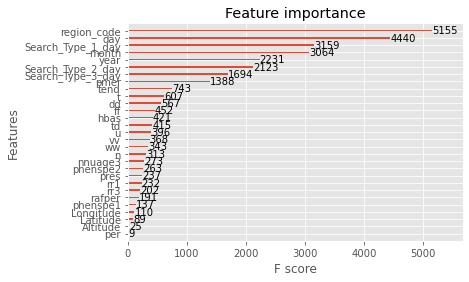

In [129]:
from xgboost import plot_importance
plot_importance(my_model_1)

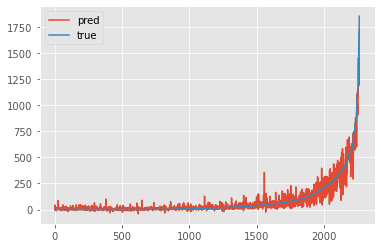

In [130]:
df_res = pd.DataFrame({'true': y_valid, 'pred': predictions_1})
df_res = df_res.sort_values('true')

plt.plot( df_res['pred'].values, label='pred')
plt.plot(df_res['true'].values, label='true')
plt.legend()
plt.show()

## Conclusion

Jusqu'à maintenant, on a implémenter un premier modèle de Machine Learning. Xtrème Gradient Bossting donne relativement de bons résultats, avec un RMSE = 41.51.

Nous pourrons retravailler nos variables, afin de pouvoir améliorer les prédictions, comme la création de nouvelles variables, traitement des valeurs manquantes lors de jointure, et la multiconinéarité,  ainsi que l'application des différe,ts algorithmes en utilisant GridSearch, afin de trouver les meilleurs paramètres.